In [14]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset
from PIL import Image

In [29]:
class SRDataset(Dataset):
    def __init__(self, lr_dir, hr_dir, transform1=None, transform2=None):
        super(SRDataset, self).__init__()
        self.lr_dir = lr_dir
        self.hr_dir = hr_dir
        self.transform1 = transform1
        self.transform2 = transform2
        self.lr_images = sorted(os.listdir(lr_dir))
        self.hr_images = sorted(os.listdir(hr_dir))
    
    def __len__(self):
        return len(self.lr_images)
    
    def __getitem__(self, idx):
        # Load the low-resolution image
        lr_img_path = os.path.join(self.lr_dir, self.lr_images[idx])
        lr_img = Image.open(lr_img_path)
        
        # Load the corresponding high-resolution image
        hr_img_path = os.path.join(self.hr_dir, self.hr_images[idx])
        hr_img = Image.open(hr_img_path)
        
        if self.transform1 or self.transform2:
            lr_img = self.transform1(lr_img)  # Apply transformations on LR image
            hr_img = self.transform2(hr_img)  # Apply transformations on HR image
        
        return lr_img, hr_img

# Define image transformations (convert images to PyTorch tensors and normalize them)
# Assuming a 4x super-resolution task: resize LR to 64x64 and HR to 256x256

lr_transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize LR images to 64x64
    transforms.ToTensor(),        # Convert image to PyTorch tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

hr_transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize HR images to 256x256
    transforms.ToTensor(),          # Convert image to PyTorch tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

# Create Dataset and DataLoader for training and validation sets
train_dataset = SRDataset(lr_dir='train_LR', hr_dir='train_HR', transform1=lr_transform, transform2=hr_transform)
val_dataset = SRDataset(lr_dir='val_LR', hr_dir='val_HR', transform1=lr_transform, transform2=hr_transform)

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=0)

In [30]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_channels),
            nn.PReLU(),
            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_channels)
        )

    def forward(self, x):
        return x + self.block(x)

class Generator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, num_residual_blocks=16):
        super(Generator, self).__init__()

        # Initial Convolution Block
        self.initial = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=9, stride=1, padding=4),
            nn.PReLU()
        )

        # Residual Blocks
        res_blocks = []
        for _ in range(num_residual_blocks):
            res_blocks.append(ResidualBlock(64))

        self.residual_blocks = nn.Sequential(*res_blocks)

        # Convolution before upsampling
        self.conv_before_upsample = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64)
        )

        # Upsampling Layers (PixelShuffle)
        self.upsample = nn.Sequential(
            nn.Conv2d(64, 256, kernel_size=3, stride=1, padding=1),
            nn.PixelShuffle(2),
            nn.PReLU(),
            nn.Conv2d(64, 256, kernel_size=3, stride=1, padding=1),
            nn.PixelShuffle(2),
            nn.PReLU()
        )

        # Final Output Layer
        self.final = nn.Conv2d(64, out_channels, kernel_size=9, stride=1, padding=4)

    def forward(self, x):
        initial = self.initial(x)
        res_output = self.residual_blocks(initial)
        res_output = self.conv_before_upsample(res_output)
        upsampled = self.upsample(res_output + initial)
        return self.final(upsampled)

In [31]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            # Conv Block 1
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            # Conv Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            # Conv Block 3
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            # Conv Block 4
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.AdaptiveAvgPool2d((6, 6))
        )

        self.fc = nn.Sequential(
            nn.Linear(512 * 6 * 6, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        out = self.model(x)
        out = out.view(out.size(0), -1)
        return self.fc(out)

In [32]:
class VGGLoss(nn.Module):
    def __init__(self):
        super(VGGLoss, self).__init__()
        vgg = models.vgg19(pretrained=True).features
        self.vgg = nn.Sequential(*list(vgg.children())[:36]).eval()
        for param in self.vgg.parameters():
            param.requires_grad = False
        self.loss = nn.MSELoss()

    def forward(self, sr, hr):
        sr_vgg_features = self.vgg(sr)
        hr_vgg_features = self.vgg(hr)
        return self.loss(sr_vgg_features, hr_vgg_features)

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize generator and discriminator
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Loss functions
adversarial_loss = nn.BCELoss().to(device)
pixel_loss = nn.MSELoss().to(device)
vgg_loss = VGGLoss().to(device)

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=1e-4, betas=(0.9, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=1e-4, betas=(0.9, 0.999))

c:\Users\Sai Krishna\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Sai Krishna\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [35]:
# Training loop
epochs = 10
for epoch in range(epochs):
    generator.train()
    discriminator.train()
    for i, (lr_imgs, hr_imgs) in enumerate(train_dataloader):
        # Move data to the device (CPU or GPU)
        lr_imgs = lr_imgs.to(device)
        hr_imgs = hr_imgs.to(device)

        # Train Discriminator
        optimizer_D.zero_grad()
        fake_hr_imgs = generator(lr_imgs)
        real_labels = torch.ones(hr_imgs.size(0), 1).to(device)
        fake_labels = torch.zeros(hr_imgs.size(0), 1).to(device)
        real_loss = adversarial_loss(discriminator(hr_imgs), real_labels)
        fake_loss = adversarial_loss(discriminator(fake_hr_imgs.detach()), fake_labels)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        g_loss_pixel = pixel_loss(fake_hr_imgs, hr_imgs)
        g_loss_vgg = vgg_loss(fake_hr_imgs, hr_imgs)
        g_loss_adv = adversarial_loss(discriminator(fake_hr_imgs), real_labels)
        g_loss = g_loss_pixel + 0.006 * g_loss_vgg + 1e-3 * g_loss_adv
        g_loss.backward()
        optimizer_G.step()

        # Logging
        print(f"Epoch [{epoch}/{epochs}], d_loss: {d_loss.item()}, g_loss: {g_loss.item()}")

Epoch [0/10], d_loss: 0.6735100150108337, g_loss: 0.2739250957965851
Epoch [0/10], d_loss: 0.7451516389846802, g_loss: 0.22048810124397278
Epoch [0/10], d_loss: 0.6519596576690674, g_loss: 0.3271137475967407
Epoch [0/10], d_loss: 0.3816556930541992, g_loss: 0.2672627866268158
Epoch [0/10], d_loss: 0.45792123675346375, g_loss: 0.19513702392578125
Epoch [0/10], d_loss: 0.542823314666748, g_loss: 0.10440608114004135
Epoch [0/10], d_loss: 0.3926961421966553, g_loss: 0.2163381576538086
Epoch [0/10], d_loss: 0.3390522003173828, g_loss: 0.1587868481874466
Epoch [0/10], d_loss: 0.4112418293952942, g_loss: 0.09457752108573914
Epoch [0/10], d_loss: 0.6342833042144775, g_loss: 0.15477508306503296
Epoch [0/10], d_loss: 0.22626319527626038, g_loss: 0.1671787053346634
Epoch [0/10], d_loss: 0.44828683137893677, g_loss: 0.10378032922744751
Epoch [0/10], d_loss: 0.23689012229442596, g_loss: 0.1094389408826828
Epoch [0/10], d_loss: 0.09472917020320892, g_loss: 0.13352163136005402
Epoch [0/10], d_loss: 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


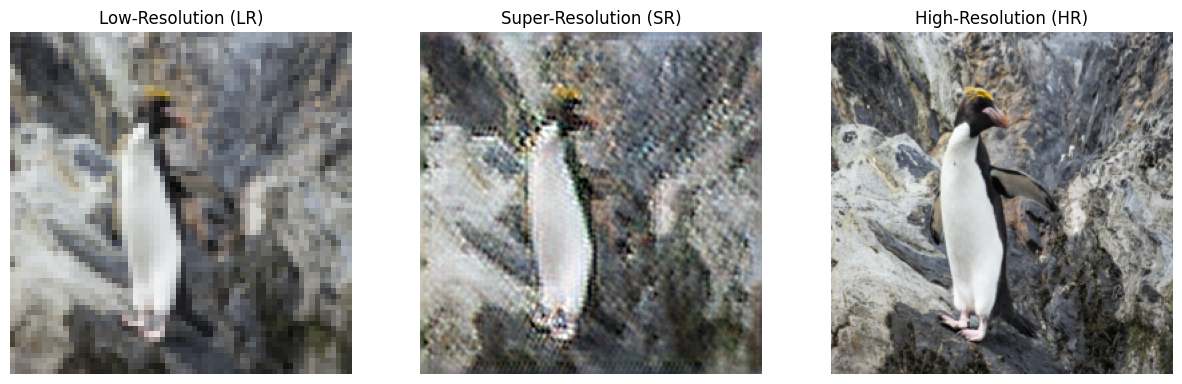

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


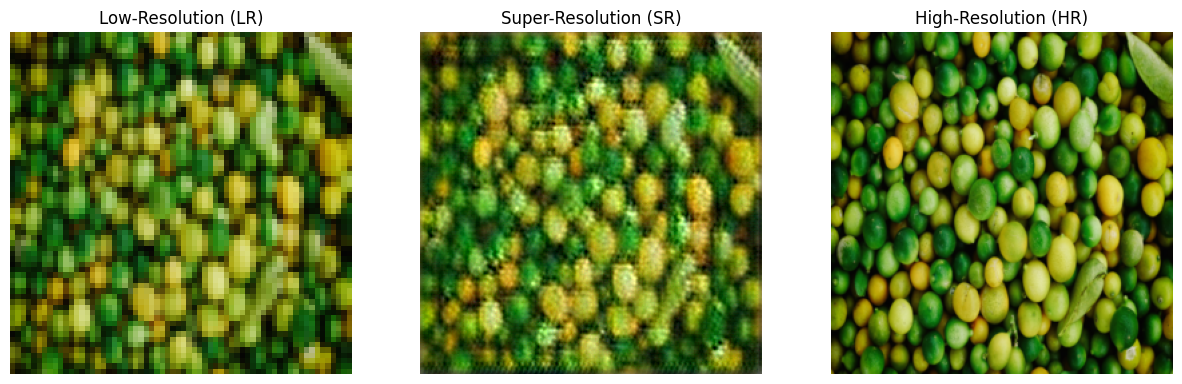

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


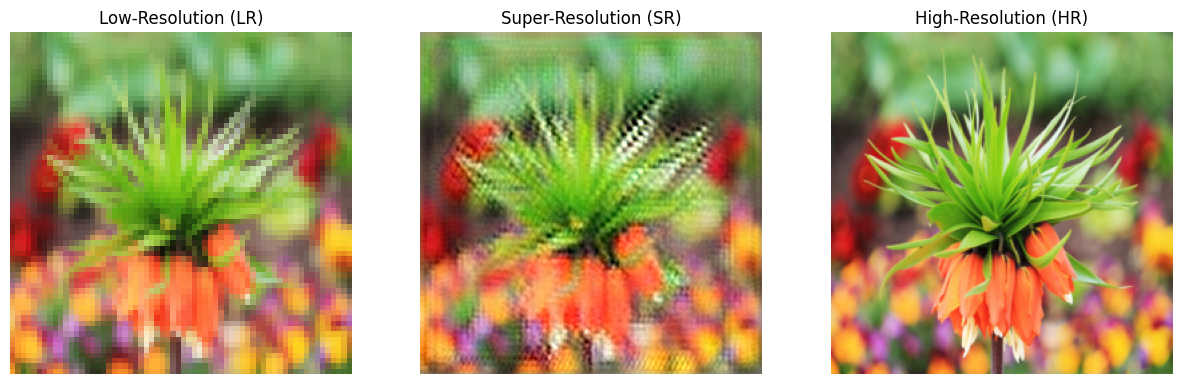

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


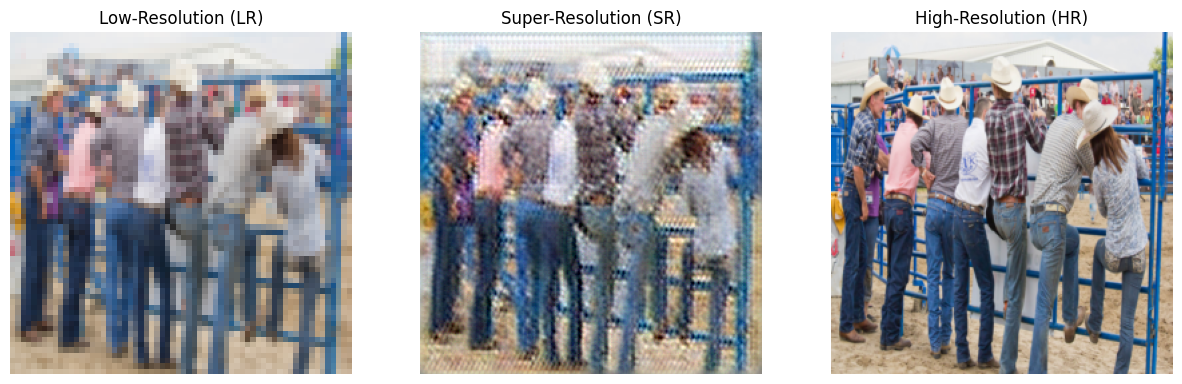

In [36]:
from torchvision.utils import save_image
import matplotlib.pyplot as plt

# Function to save or display images
def save_and_display_images(lr_img, sr_img, hr_img, index):
    # Save images to disk (optional)
    save_image(lr_img, f"lr_image_{index}.png")
    save_image(sr_img, f"sr_image_{index}.png")
    save_image(hr_img, f"hr_image_{index}.png")
    
    # Convert images to numpy format for displaying using matplotlib
    lr_img_np = lr_img.cpu().numpy().transpose(1, 2, 0)  # Convert to HxWxC
    sr_img_np = sr_img.cpu().numpy().transpose(1, 2, 0)
    hr_img_np = hr_img.cpu().numpy().transpose(1, 2, 0)
    
    # Plot the images side by side
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    
    ax[0].imshow(lr_img_np * 0.5 + 0.5)  # Denormalize [-1, 1] to [0, 1]
    ax[0].set_title("Low-Resolution (LR)")
    ax[0].axis("off")
    
    ax[1].imshow(sr_img_np * 0.5 + 0.5)  # Denormalize
    ax[1].set_title("Super-Resolution (SR)")
    ax[1].axis("off")
    
    ax[2].imshow(hr_img_np * 0.5 + 0.5)  # Denormalize
    ax[2].set_title("High-Resolution (HR)")
    ax[2].axis("off")
    
    plt.show()

# Set the generator to evaluation mode
generator.eval()

# Disable gradients for faster inference
with torch.no_grad():
    # Loop over the validation dataset or a few images for testing
    for idx, (lr_imgs, hr_imgs) in enumerate(val_dataloader):
        lr_imgs = lr_imgs.to(device)
        hr_imgs = hr_imgs.to(device)
        
        # Generate super-resolution images from LR input
        sr_imgs = generator(lr_imgs)
        
        # Loop through the batch and save/display individual images
        for i in range(lr_imgs.size(0)):
            save_and_display_images(lr_imgs[i], sr_imgs[i], hr_imgs[i], idx * lr_imgs.size(0) + i)
        
        # Optionally break after a few batches for testing (if you don't want to display the entire validation set)
        break
